# Bayesian Networks for Image Classification (High Quality)

In [2]:
import os
import splitfolders 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

## Load the Data (CIFAR-10)
Load the data from the tensorflow datasets library. <br>

The datasets are automatically divided between training and testing, so no need of extra steps for splitting them. <br>

In [18]:
# Get training and testings sets (x is images, y is labels)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Encode the labels to 10 values (for BCNN)
y_train_bcnn = tf.keras.utils.to_categorical(y_train, 10)
y_test_bcnn = tf.keras.utils.to_categorical(y_test, 10)

# Reshape the labels to 1 array (for CNN)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Print the set shapes
print("Training Image Size:", x_train.shape)
print("Training Labels Size:", y_train.shape)
print("Testing Image Size:", x_test.shape)
print("Testing Labels Size:", y_test.shape)

Training Image Size: (50000, 32, 32, 3)
Training Labels Size: (50000, 1)
Testing Image Size: (10000, 32, 32, 3)
Testing Labels Size: (10000, 1)


## Plot Dataset
Plot an initial graph of our dataset images. <br>

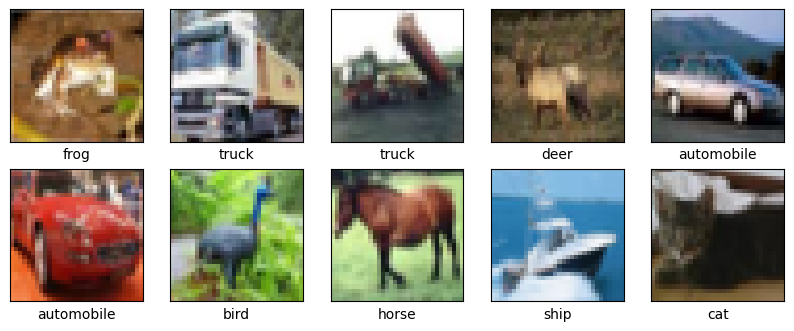

In [9]:
# Get all the label names for the dataset 
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot a graph with labels and associated images
plt.figure(figsize=(10,10))
for i in range(len(label_names)):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(label_names[y_train[i][0]])
plt.show()

## Standard Convolutional Neural Network (CNN) Model
Before we start creating / building a model with Bayesian perspective, we will first build an image classification model with the standard CNN model. Using this, we can compare how Bayesian CNN differs from the standard CNN. <br>

To build the model, we’re going to use standard CNN with TensorFlow. The model consists of four convolutional layers before we flatten it and use a dense layer at the very end. <br>

In [10]:
# Create early stoppage callback (will stop with 5 epochs of not improving accuracy)
callback = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=5)

# Create the Standard CNN Model
cnn_model = Sequential([
    Conv2D(32, (3,3), input_shape=(32, 32, 3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10)
])

# Summarize the model
cnn_model.summary()

# Compile the model
cnn_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [11]:
# Train the model (50 epochs)
cnn_history = cnn_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[callback])

# Evaluate the model
loss, accuracy = cnn_model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2023-05-18 20:09:48.383315: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
1561/1563 [============================>.] - ETA: 0s - loss: 1.5707 - acc: 0.4243

2023-05-18 20:10:58.094338: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


1563/1563 [==============================] - 64s 40ms/step - loss: 1.5704 - acc: 0.4244 - val_loss: 1.2974 - val_acc: 0.5272
Epoch 2/50
1563/1563 [==============================] - 48s 31ms/step - loss: 1.2113 - acc: 0.5668 - val_loss: 1.1035 - val_acc: 0.6081
Epoch 3/50
1563/1563 [==============================] - 41s 26ms/step - loss: 1.0541 - acc: 0.6305 - val_loss: 1.0991 - val_acc: 0.6119
Epoch 4/50
1563/1563 [==============================] - 42s 27ms/step - loss: 0.9611 - acc: 0.6635 - val_loss: 0.9734 - val_acc: 0.6614
Epoch 5/50
1563/1563 [==============================] - 41s 26ms/step - loss: 0.8876 - acc: 0.6885 - val_loss: 0.9811 - val_acc: 0.6608
Epoch 6/50
1563/1563 [==============================] - 46s 29ms/step - loss: 0.8352 - acc: 0.7063 - val_loss: 0.9081 - val_acc: 0.6900
Epoch 7/50
1563/1563 [==============================] - 52s 33ms/step - loss: 0.7869 - acc: 0.7262 - val_loss: 0.8887 - val_acc: 0.6948
Epoch 8/50
1563/1563 [==============================] - 54s

2023-05-18 20:48:38.951839: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 3s 11ms/step - loss: 1.7745 - acc: 0.6845
Test Loss: 1.7744581699371338
Test Accuracy: 0.684499979019165


## Evaluate the Model (CNN)
In this section, we evaluate the CNN model based on its training process. <br>

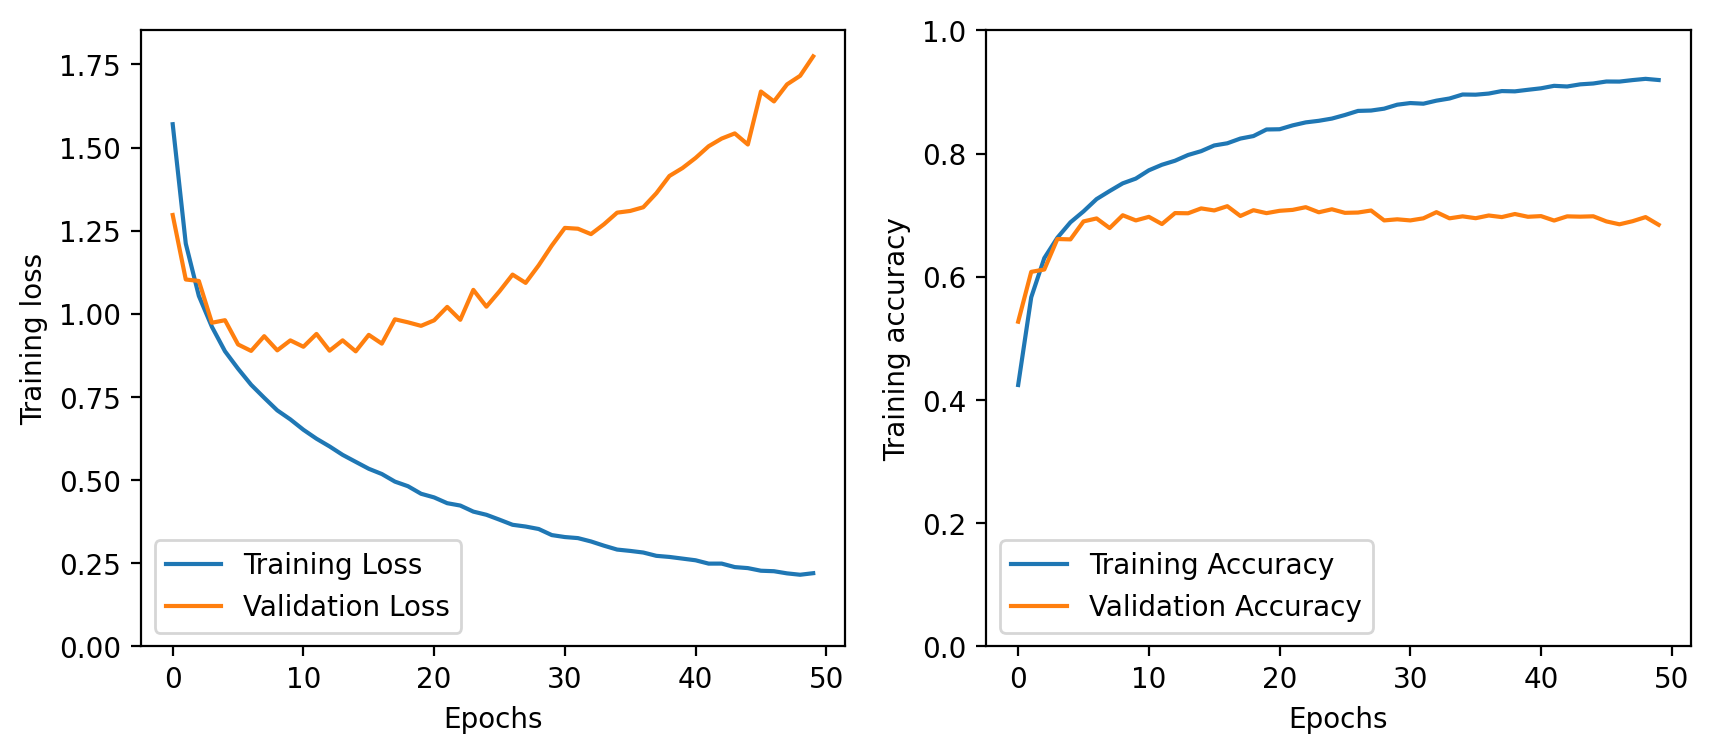

In [12]:
# Plot the model's training process
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
# Plot the Loss
ax[0].plot(range(50), cnn_history.history['loss'], label='Training Loss')
ax[0].plot(range(50), cnn_history.history['val_loss'], label='Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[0].set_ylim([0, None])
# Plot the accuracy
ax[1].plot(range(50), cnn_history.history['acc'], label='Training Accuracy')
ax[1].plot(range(50), cnn_history.history['val_acc'], label="Validation Accuracy")
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training accuracy')

plt.show()

## Bayesian (Networks) CNN Model (BCNN)
In order to build a Bayesian CNN (BCNN), we’re going to use TensorFlow Probability library and then replace the CNN layers with their Bayesian equivalent. <br>

In [19]:
# Set the random seed of Tensorflow
tf.random.set_seed(0)

# Create early stoppage callback (will stop with 5 epochs of not improving accuracy)
callback = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=5)

# Get the Tensorflow libraries
tfd = tfp.distributions
tfpl = tfp.layers

# Get the variational divergence ()
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train.shape[0]

# Create the custom prior Spike and Slab (scale mixture prior) distribution
def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)], name='spike_and_slab')
    return distribution

# Create the prior distribution
def get_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size+bias_size  
    prior_model = Sequential([tfpl.DistributionLambda(lambda t : spike_and_slab(n, dtype))])
    return prior_model

# Create the posterior distribution
def get_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

# Create the DenseVariational layer
def get_dense_variational_layer(prior_fn, posterior_fn, kl_weight):
    return tfpl.DenseVariational(
        units=10, make_posterior_fn=posterior_fn, make_prior_fn=prior_fn, kl_weight=kl_weight
    )

# Create the DenseVariational layer using the previous functions
dense_variational_layer = get_dense_variational_layer(get_prior, get_posterior, kl_weight=1/x_train.shape[0])

# Create the Bayesian Network (BCNN) model
bcnn_model = Sequential([
        tfpl.Convolution2DReparameterization(
                input_shape=(32, 32, 3), filters=8, kernel_size=(5, 5),
                activation='relu', padding='VALID',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn),
        MaxPooling2D(pool_size=(6, 6)),
        Flatten(),
        dense_variational_layer,
        tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])

# Create the loss function for our Bayesian CNN model to maximize the likelihood estimate of the mean and the standard deviation of the weights
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Compile the model (use categorical_crossentropy as we have 10 labels and keras API automatically adds Kullback-Leibler divergence to the cross entropy loss -> calculates ELBO)
bcnn_model.compile(optimizer= RMSprop(), loss=negative_log_likelihood, metrics=['acc'], experimental_run_tf_function=False)

# Summarize the model
bcnn_model.summary()

/home/deeep/.local/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/deeep/.local/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_1  (None, 28, 28, 8)        1216      
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_variational_1 (DenseV  (None, 10)               2580      
 ariational)                                                     
                                                                 
 one_hot_categorical_1 (OneH  ((None, 10),             0         
 otCategorical)               (None, 10))             

In [20]:
# Train the model (more expensive)
bcnn_history = bcnn_model.fit(x_train, y_train_bcnn, epochs=50, validation_data=(x_test, y_test_bcnn), callbacks=[callback])

# Evaluate the model
loss, accuracy = bcnn_model.evaluate(x_test, y_test_bcnn)
print("Test Loss:", loss)   
print("Test Accuracy:", accuracy)

Epoch 1/50
1563/1563 [==============================] - 23s 13ms/step - loss: 2.5048 - acc: 0.0993 - val_loss: 2.4139 - val_acc: 0.1029
Epoch 2/50
1563/1563 [==============================] - 19s 12ms/step - loss: 2.3727 - acc: 0.1131 - val_loss: 2.3266 - val_acc: 0.1298
Epoch 3/50
1563/1563 [==============================] - 23s 15ms/step - loss: 2.3033 - acc: 0.1502 - val_loss: 2.2750 - val_acc: 0.1645
Epoch 4/50
1563/1563 [==============================] - 21s 13ms/step - loss: 2.2450 - acc: 0.1822 - val_loss: 2.3134 - val_acc: 0.2001
Epoch 5/50
1563/1563 [==============================] - 20s 13ms/step - loss: 2.1763 - acc: 0.2145 - val_loss: 2.1434 - val_acc: 0.2219
Epoch 6/50
1563/1563 [==============================] - 18s 12ms/step - loss: 2.1341 - acc: 0.2319 - val_loss: 2.0970 - val_acc: 0.2418
Epoch 7/50
1563/1563 [==============================] - 19s 12ms/step - loss: 2.0910 - acc: 0.2474 - val_loss: 2.0394 - val_acc: 0.2698
Epoch 8/50
1563/1563 [==========================

## Evaluate the Model (BCNN)
In this section, we evaluate the BCNN model based on its training process. <br>

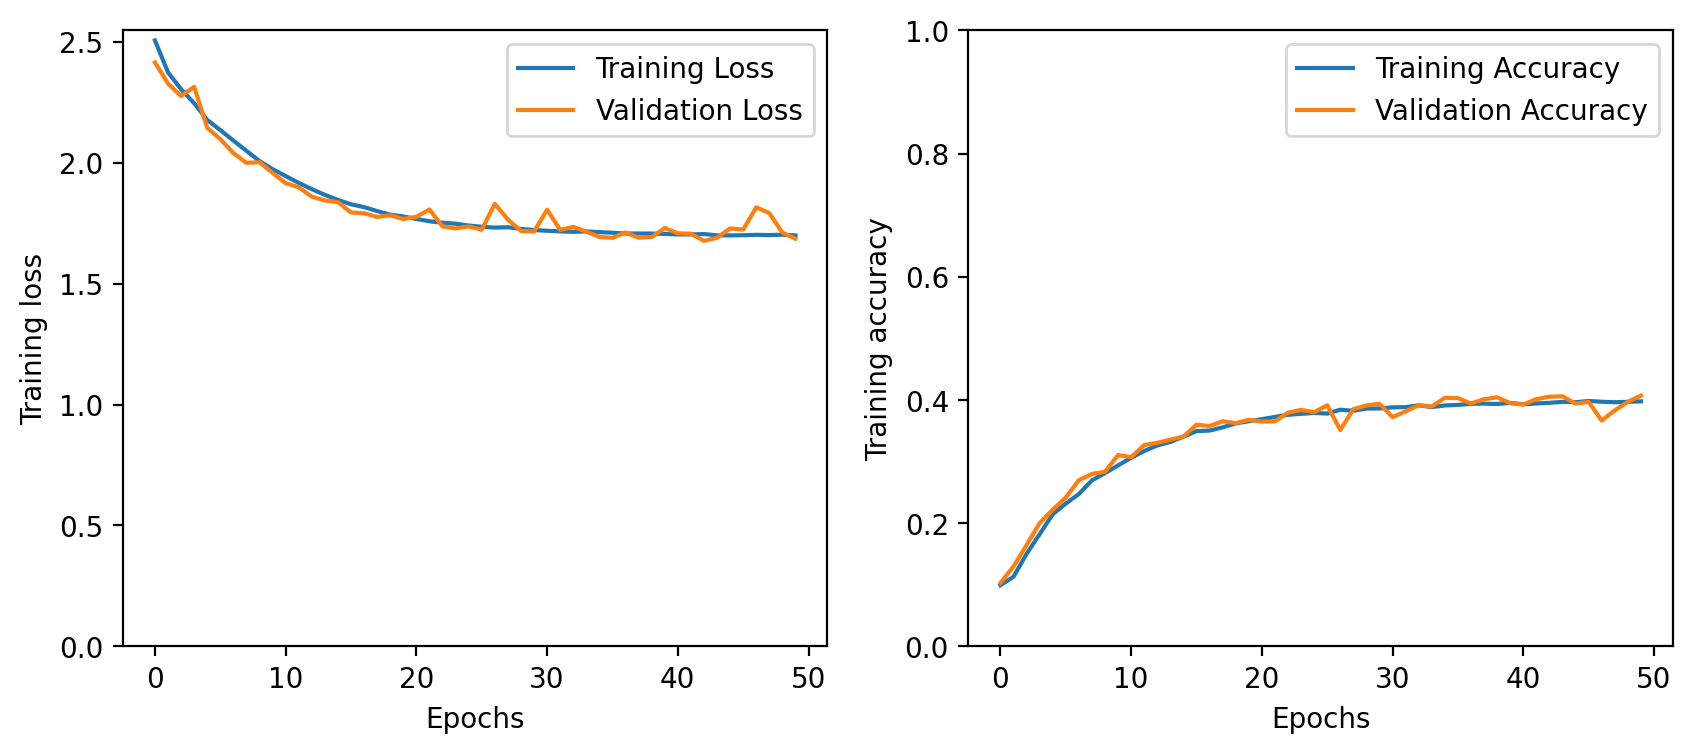

In [21]:
# Plot the model's training process
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
# Plot the Loss
ax[0].plot(range(50), bcnn_history.history['loss'], label='Training Loss')
ax[0].plot(range(50), bcnn_history.history['val_loss'], label='Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[0].set_ylim([0, None])
# Plot the accuracy
ax[1].plot(range(50), bcnn_history.history['acc'], label='Training Accuracy')
ax[1].plot(range(50), bcnn_history.history['val_acc'], label="Validation Accuracy")
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training accuracy')

plt.show()

# Create the model Predictions (BCNN)
Use the created function to plot the BCNN model predictions. <br>

This allows us to do some deeper analysis by looking at the probabilities the model assigns to each class instead of its single prediction. <br>

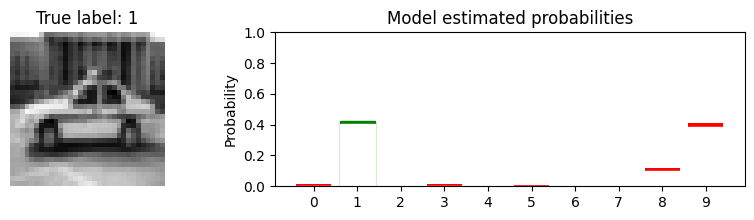

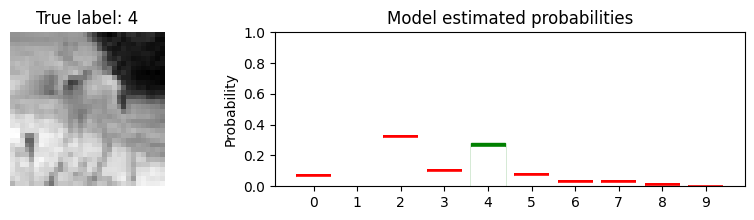

In [24]:
# Create a function to analyse model predictions
def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num, 0]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1]) 
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()
# Run the function to analyse mode predictions
for i in [104, 100]:
    analyse_model_prediction(x_test, y_test, bcnn_model, i, run_ensemble=False)